# **Numerical Experiments for Exact models**

In [1]:
import sys

sys.path.insert(0,"./../tests/numerical") # clue_example is here
sys.path.insert(0,"./../") # clue is here

from clue import *
from numerical_example import *
from sympy import RR
import pandas as pd
import time
from alive_progress import alive_bar

## Some example lines

In [6]:
## This line can run an example just providing the name of the example
run_exact("ProteinPhosphorylation[2]")

2023-03-15 14:39:19 Level 60 [run_exact] Reading the system both exactly and numerical
2023-03-15 14:39:19 Level 60 [run_exact] Removing the parameters of the system
2023-03-15 14:39:19 Level 60 [run_exact] Obtaining the initial condition from the system
2023-03-15 14:39:19 Level 60 [run_exact] Initial state of the problem: ||x_0|| = 3029.8630315576975 -- ||f(x_0)|| = 1992234.925906079
2023-03-15 14:39:19 Level 60 [run_exact] Computing numerical simulation for the exact system (t0=0.0,t1=0.00125,tstep=6.25e-06)
2023-03-15 14:39:21 Level 60 [run_exact] Building observables
2023-03-15 14:39:21 Level 60 [run_exact] Computing the exact lumping for each observable
2023-03-15 14:39:21 Level 60 [run_exact] Creating the result structures
2023-03-15 14:39:21 Level 60 [run_exact] Running each of the cases
2023-03-15 14:39:21 Level 60 [run_exact] Computing (if needed) epsilon for ProteinPhosphorylation[2] (r=polynomial,m=polynomial) (C=3029.8630315576975; 100.0% slope = 1992234.925906079) [S0, S1

In [2]:
## This line can compile all the executed examples
compile_results()

2023-03-15 14:40:44 Level 60 [compile_results] Compiling results for ProteinPhosphorylation[2] with read='polynomial' and matrix='polynomial'...
2023-03-15 14:40:44 INFO     [from_file] Read case ProteinPhosphorylation[2] (r=polynomial,m=polynomial) (C=3029.8630315576975; 100.0% slope = 1992234.925906079) [S0, S1]
2023-03-15 14:40:44 INFO     [from_file] Read case ProteinPhosphorylation[2] (r=polynomial,m=polynomial) (C=3029.8630315576975; 1000.0% slope = 19922349.25906079) [S0, S1]
2023-03-15 14:40:44 INFO     [from_file] Read case ProteinPhosphorylation[2] (r=polynomial,m=polynomial) (C=3029.8630315576975; 10000.0% slope = 199223492.59060788) [S0, S1]
2023-03-15 14:40:44 Level 60 [compile_results] Compiling results for BioNetGen_CCP with read='polynomial' and matrix='polynomial'...
2023-03-15 14:40:44 INFO     [from_file] Read case BioNetGen_CCP (r=polynomial,m=polynomial) (C=1.0; 10.0% slope = 0.1) [s18 + s40]
2023-03-15 14:40:44 INFO     [from_file] Read case BioNetGen_CCP (r=polyn

In [2]:
## We can read the results using this line
compilation = pd.read_csv('../tests/numerical/compilation.csv', sep=';')
compilation

,modelName,type,maxPerturbation,size,clum_size,nlum_size,et_rel,et,|M*xt|_2,epsilon,...,max_allowed_slope,avg_err,max_err,max_epsilon,consideredEpsilons,tolerance,t0,t1,secThisEpsilon,secTotal
0,"ProteinPhosphorylation[2]_[S0, S1]_0.0",polynomial,0.0,24,12,12,1.157190e-05,3.469887e-03,299.854673,0.540061,...,1.0,2.616639e-02,2.807540e-01,3.162278,23,0.000001,0.0,1.250000e-03,21.696005,21.899352
1,"ProteinPhosphorylation[2]_[S0, S1]_0.0",polynomial,0.0,24,12,10,1.044993e-04,3.133461e-02,299.854673,1.999999,...,10.0,3.069643e-02,2.807537e-01,3.162278,23,0.000001,0.0,1.250000e-03,6.287768,6.440981
2,"ProteinPhosphorylation[2]_[S0, S1]_0.0",polynomial,0.0,24,12,10,1.044993e-04,3.133461e-02,299.854673,1.999999,...,100.0,3.069643e-02,2.807537e-01,3.162278,23,0.000001,0.0,1.250000e-03,0.105409,0.252448
3,BioNetGen_CCP_[s18 + s40]_0.0,polynomial,0.0,87,30,30,3.788951e-04,2.867030e-04,0.756682,0.105549,...,0.1,5.424762e-05,3.205928e-04,2.828427,23,0.000001,0.0,5.000000e+00,499.674802,510.028255
4,BioNetGen_CCP_[s18 + s40]_0.0,polynomial,0.0,87,30,28,1.988686e-03,1.504803e-03,0.756682,0.106066,...,0.2,2.183369e-04,1.504803e-03,2.828427,23,0.000001,0.0,5.000000e+00,49.742580,56.616679
5,BioNetGen_CCP_[s18 + s40]_0.0,polynomial,0.0,87,30,23,4.162884e-04,3.149979e-04,0.756682,0.267121,...,0.3,6.628130e-05,3.149979e-04,2.828427,23,0.000001,0.0,5.000000e+00,96.663120,102.431618
6,BioNetGen_CCP_[s18 + s40]_0.0,polynomial,0.0,87,30,9,2.267251e-02,1.715588e-02,0.756682,0.728105,...,0.4,2.703158e-03,1.715588e-02,2.828427,23,0.000001,0.0,5.000000e+00,100.646201,101.670099
7,BioNetGen_CCP_[s18 + s40]_0.0,polynomial,0.0,87,30,9,2.267251e-02,1.715588e-02,0.756682,0.728105,...,0.5,2.703158e-03,1.715588e-02,2.828427,23,0.000001,0.0,5.000000e+00,32.660773,33.721693
8,BioNetGen_CCP_[s0 + s34]_0.0,polynomial,0.0,87,4,4,1.512903e-06,8.397568e-07,0.555063,0.289999,...,0.1,1.030052e-05,3.380308e-05,0.290000,20,0.000001,0.0,5.000000e+00,95.504543,95.844915
9,BioNetGen_CCP_[s0 + s34]_0.0,polynomial,0.0,87,4,4,1.512903e-06,8.397568e-07,0.555063,0.290000,...,0.2,1.030052e-05,3.380308e-05,0.290000,1,0.000001,0.0,5.000000e+00,0.003051,0.315798


## Exploring limits for each example

### ProteinPhosphorylation[2]

In [2]:
example = get_example("ProteinPhosphorylation[2]")
system = FODESystem(file=example.path_model(), read_ic = True, parser=example.read).remove_parameters_ic()
RRsystem = FODESystem(file=example.path_model(), read_ic = True, parser=example.read, field = RR).remove_parameters_ic()
x0 = array([float(RRsystem.ic.get(v, 0)) for v in RRsystem.variables])
norm_x0 = norm(x0, ord=2)
fx0 = array(RRsystem.derivative(..., *x0), dtype=x0.dtype)
norm_fx0 = norm(fx0, ord=2)
print(f"Original system size: {RRsystem.size}")
print(f"Initial state: |x_0| = {norm_x0} ## |f(x_0)| = {norm_fx0}")

Original system size: 24
Initial state: |x_0| = 3029.8630315576975 ## |f(x_0)| = 1992234.925906079


#### Checking time for simulation

In [6]:
## Defining time frame
t0 = 0.0; t1 = 10.0; tstep = (t1-t0)/200

In [7]:
%time simulation = system.simulate(t0,t1,x0,tstep)

CPU times: user 4.03 s, sys: 10.1 ms, total: 4.04 s
Wall time: 4.04 s


CPU times: user 10.2 ms, sys: 10.2 ms, total: 20.4 ms
Wall time: 19.5 ms


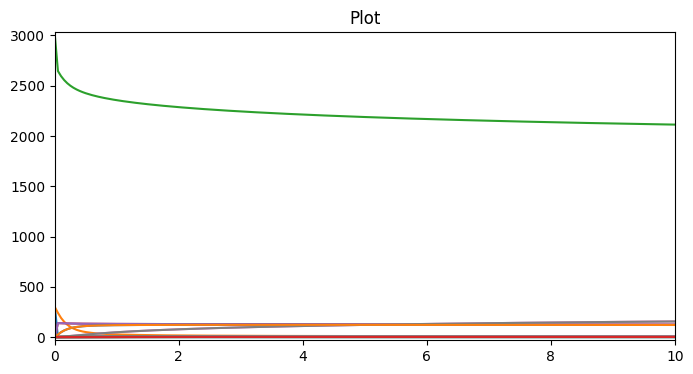

In [8]:
%time fig = create_figure(simulation, legend=False, format="-");

### BioNetGen

In [145]:
example = get_example("BioNetGen_CCP")
system = FODESystem(file=example.path_model(), read_ic = True, parser=example.read).remove_parameters_ic()
RRsystem = FODESystem(file=example.path_model(), read_ic = True, parser=example.read, field = RR).remove_parameters_ic()
x0 = array([float(RRsystem.ic.get(v, 0)) for v in RRsystem.variables])
norm_x0 = norm(x0, ord=2)
fx0 = array(RRsystem.derivative(..., *x0), dtype=x0.dtype)
norm_fx0 = norm(fx0, ord=2)
print(f"Original system size: {RRsystem.size}")
print(f"Initial state: |x_0| = {norm_x0} ## |f(x_0)| = {norm_fx0}")

Original system size: 87
Initial state: |x_0| = 1.0 ## |f(x_0)| = 1.0


#### Checking time for simulation

In [146]:
## Defining time frame
t0 = 0.0; t1 = 100.0; tstep = (t1-t0)/200

In [147]:
%time simulation = system.simulate(t0,t1,x0,tstep)

CPU times: user 301 ms, sys: 10 ms, total: 311 ms
Wall time: 308 ms


CPU times: user 33.7 ms, sys: 0 ns, total: 33.7 ms
Wall time: 33.1 ms


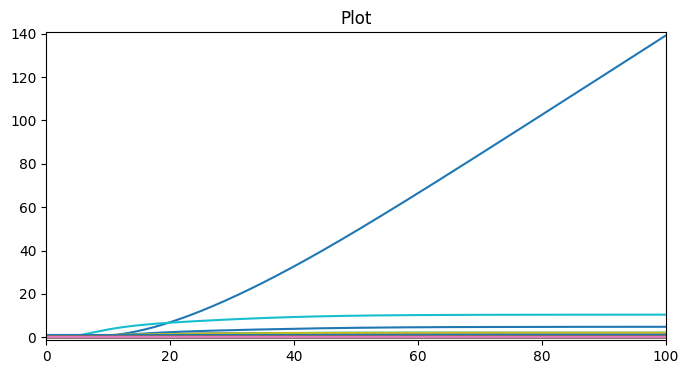

In [148]:
%time fig = create_figure(simulation, legend=False, format="-");

#### Checking maximal epsilons and deviations

In [3]:
## Computing maximal epsilon
with alive_bar(2*len(example.observables), title="Computing...", force_tty=True) as bar:
    results = {}
    for observable in example.observables:
        observable = tuple([SparsePolynomial.from_string(obs, system.variables) for obs in observable])
        ## From exact system
        ctime = time.time()
        max_epsilon_exact = system.find_maximal_threshold(observable,norm_x0, 100, 1e-6)
        time_exact = time.time()-ctime
        bar()
        ## From numerical system
        ctime = time.time()
        max_epsilon_numerical = RRsystem.find_maximal_threshold(observable,norm_x0, 100, 1e-6)
        time_numerical = time.time()-ctime
        bar()
        results[observable] = (("exact", time_exact, max_epsilon_exact), ("numerical", time_numerical, max_epsilon_numerical))
    
results

Computing... |████████████████████████████████████████| 10/10 [100%] in 2:38.7 (0.06/s)                                 


{(s18 + s40,): (('exact', 20.579288005828857, (4.0, 3.8814376430176822)),
  ('numerical', 11.120456457138062, (2.82842712474619, 2.801011940118035))),
 (s0 + s34,): (('exact',
   20.40638518333435,
   (0.41012193308819755, 0.2864843113486243)),
  ('numerical', 11.36315131187439, (0.2899999999999999, 0.21500371665095205))),
 (s1 + s66 + s67 + s68,): (('exact',
   20.707706689834595,
   (1.6, 1.6546390399508664)),
  ('numerical', 11.10129976272583, (0.8, 0.8545402899111078))),
 (s2 + s36,): (('exact',
   20.49180006980896,
   (0.41012193308819755, 0.2994986332662622)),
  ('numerical',
   11.171526193618774,
   (0.2899999999999999, 0.20466348043931923))),
 (s3 + s43,): (('exact',
   20.18851923942566,
   (0.5091168824543142, 0.19992252002652044)),
  ('numerical', 11.537360429763794, (0.36, 0.16017855662140346)))}

### BIO...013  ($t_1 = 0.4$)

In [13]:
example = get_example("BIOMD0000000013")
system = FODESystem(file=example.path_model(), read_ic = True, parser=example.read).remove_parameters_ic()
RRsystem = FODESystem(file=example.path_model(), read_ic = True, parser=example.read, field = RR).remove_parameters_ic()
x0 = array([float(RRsystem.ic.get(v, 0)) for v in RRsystem.variables])
norm_x0 = norm(x0, ord=2)
fx0 = array(RRsystem.derivative(..., *x0), dtype=x0.dtype)
norm_fx0 = norm(fx0, ord=2)
print(f"Original system size: {RRsystem.size}")
print(f"Initial state: |x_0| = {norm_x0} ## |f(x_0)| = {norm_fx0}")

Original system size: 27
Initial state: |x_0| = 5.824618359277371 ## |f(x_0)| = 1601262019.543335


In [17]:
## Defining time frame
t0 = 0.0; t1 = 0.4; tstep = (t1-t0)/200; print(t1)

0.4


In [27]:
%time simulation = system.simulate(t0,t1,x0,tstep,method="LSODA")

CPU times: user 133 ms, sys: 10 ms, total: 143 ms
Wall time: 141 ms


CPU times: user 12.7 ms, sys: 10.2 ms, total: 22.9 ms
Wall time: 22.1 ms


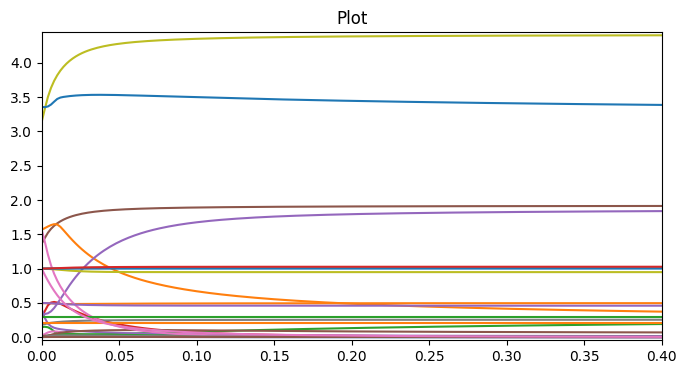

In [28]:
%time fig = create_figure(simulation, legend=False, format="-");

### BIO...023 ($t_1 = 20$)

In [29]:
example = get_example("BIOMD0000000023")
system = FODESystem(file=example.path_model(), read_ic = True, parser=example.read).remove_parameters_ic()
RRsystem = FODESystem(file=example.path_model(), read_ic = True, parser=example.read, field = RR).remove_parameters_ic()
x0 = array([float(RRsystem.ic.get(v, 0)) for v in RRsystem.variables])
norm_x0 = norm(x0, ord=2)
fx0 = array(RRsystem.derivative(..., *x0), dtype=x0.dtype)
norm_fx0 = norm(fx0, ord=2)
print(f"Original system size: {RRsystem.size}")
print(f"Initial state: |x_0| = {norm_x0} ## |f(x_0)| = {norm_fx0}")

Original system size: 13
Initial state: |x_0| = 9.060353193998564 ## |f(x_0)| = 2.6939399505014583


In [30]:
## Defining time frame
t0 = 0.0; t1 = 20.0; tstep = (t1-t0)/200

In [31]:
%time simulation = RRsystem.simulate(t0,t1,x0,tstep)

CPU times: user 9.85 ms, sys: 0 ns, total: 9.85 ms
Wall time: 10.1 ms


CPU times: user 16 ms, sys: 19 µs, total: 16 ms
Wall time: 15.3 ms


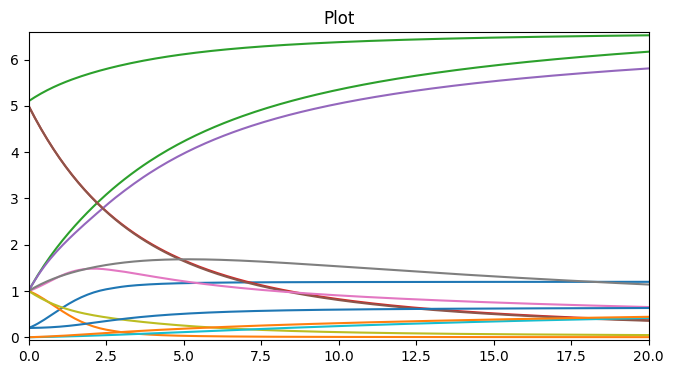

In [32]:
%time fig = create_figure(simulation, legend=False, format="-");

### BIO...113 ($t_1 = 1$)

In [33]:
example = get_example("BIOMD0000000113")
system = FODESystem(file=example.path_model(), read_ic = True, parser=example.read).remove_parameters_ic()
RRsystem = FODESystem(file=example.path_model(), read_ic = True, parser=example.read, field = RR).remove_parameters_ic()
x0 = array([float(RRsystem.ic.get(v, 0)) for v in RRsystem.variables])
norm_x0 = norm(x0, ord=2)
fx0 = array(RRsystem.derivative(..., *x0), dtype=x0.dtype)
norm_fx0 = norm(fx0, ord=2)
print(f"Original system size: {RRsystem.size}")
print(f"Initial state: |x_0| = {norm_x0} ## |f(x_0)| = {norm_fx0}")

Original system size: 6
Initial state: |x_0| = 2.1406774628607645 ## |f(x_0)| = 6.889146250310192


In [40]:
## Defining time frame
t0 = 0.0; t1 = 1; tstep = (t1-t0)/200

In [41]:
%time simulation = RRsystem.simulate(t0,t1,x0,tstep)

CPU times: user 27.9 ms, sys: 0 ns, total: 27.9 ms
Wall time: 26.8 ms


CPU times: user 18.9 ms, sys: 0 ns, total: 18.9 ms
Wall time: 18.2 ms


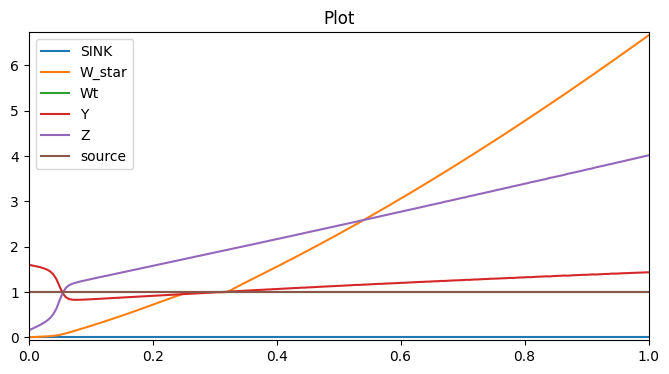

In [42]:
%time fig = create_figure(simulation, legend=True, format="-");

### BIO...182 ($t_1 = 0.01$)(lumping slow)

In [73]:
example = get_example("BIOMD0000000182")
system = FODESystem(file=example.path_model(), read_ic = True, parser=example.read).remove_parameters_ic()
RRsystem = FODESystem(file=example.path_model(), read_ic = True, parser=example.read, field = RR).remove_parameters_ic()
x0 = array([float(RRsystem.ic.get(v, 0)) for v in RRsystem.variables])
norm_x0 = norm(x0, ord=2)
fx0 = array(RRsystem.derivative(..., *x0), dtype=x0.dtype)
norm_fx0 = norm(fx0, ord=2)
print(f"Original system size: {RRsystem.size}")
print(f"Initial state: |x_0| = {norm_x0} ## |f(x_0)| = {norm_fx0}")

Original system size: 36
Initial state: |x_0| = 4256787.674822413 ## |f(x_0)| = 12708187010.319235


In [74]:
## Defining time frame
t0 = 0.0; t1 = 0.01; tstep = (t1-t0)/200; print(t1)

0.01


In [75]:
%time simulation = RRsystem.simulate(t0,t1,x0,tstep)

CPU times: user 691 ms, sys: 0 ns, total: 691 ms
Wall time: 691 ms


CPU times: user 26.1 ms, sys: 0 ns, total: 26.1 ms
Wall time: 24.7 ms


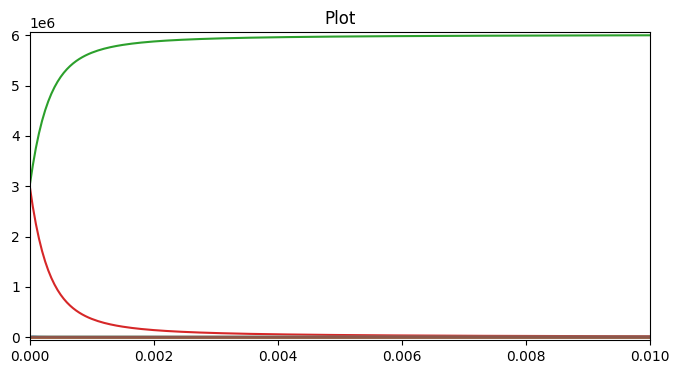

In [76]:
%time fig = create_figure(simulation, legend=False, format="-");

### BIO...313 ($t_1=2$)

In [77]:
example = get_example("BIOMD0000000313")
system = FODESystem(file=example.path_model(), read_ic = True, parser=example.read).remove_parameters_ic()
RRsystem = FODESystem(file=example.path_model(), read_ic = True, parser=example.read, field = RR).remove_parameters_ic()
x0 = array([float(RRsystem.ic.get(v, 0)) for v in RRsystem.variables])
norm_x0 = norm(x0, ord=2)
fx0 = array(RRsystem.derivative(..., *x0), dtype=x0.dtype)
norm_fx0 = norm(fx0, ord=2)
print(f"Original system size: {RRsystem.size}")
print(f"Initial state: |x_0| = {norm_x0} ## |f(x_0)| = {norm_fx0}")

Original system size: 17
Initial state: |x_0| = 219.8375018871894 ## |f(x_0)| = 24.32356322749757


In [84]:
## Defining time frame
t0 = 0.0; t1 = 2.0; tstep = (t1-t0)/200

In [85]:
%time simulation = RRsystem.simulate(t0,t1,x0,tstep)

CPU times: user 4.68 ms, sys: 0 ns, total: 4.68 ms
Wall time: 4.28 ms


CPU times: user 17.6 ms, sys: 0 ns, total: 17.6 ms
Wall time: 16.9 ms


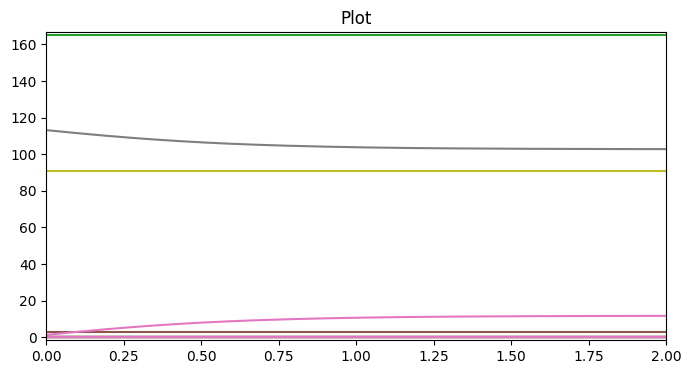

In [86]:
%time fig = create_figure(simulation, legend=False, format="-");

### BIO...448 ($t_1 = 0.0001$)

In [87]:
example = get_example("BIOMD0000000448")
system = FODESystem(file=example.path_model(), read_ic = True, parser=example.read).remove_parameters_ic()
RRsystem = FODESystem(file=example.path_model(), read_ic = True, parser=example.read, field = RR).remove_parameters_ic()
x0 = array([float(RRsystem.ic.get(v, 0)) for v in RRsystem.variables])
norm_x0 = norm(x0, ord=2)
fx0 = array(RRsystem.derivative(..., *x0), dtype=x0.dtype)
norm_fx0 = norm(fx0, ord=2)
print(f"Original system size: {RRsystem.size}")
print(f"Initial state: |x_0| = {norm_x0} ## |f(x_0)| = {norm_fx0}")

Original system size: 27
Initial state: |x_0| = 285.97887054252095 ## |f(x_0)| = 121558889085.96109


In [100]:
## Defining time frame
t0 = 0.0; t1 = 1e-4; tstep = (t1-t0)/200; print(t1)

0.0001


In [101]:
%time simulation = RRsystem.simulate(t0,t1,x0,tstep)

CPU times: user 16.4 s, sys: 5.04 ms, total: 16.5 s
Wall time: 16.4 s


CPU times: user 22.7 ms, sys: 0 ns, total: 22.7 ms
Wall time: 21.8 ms


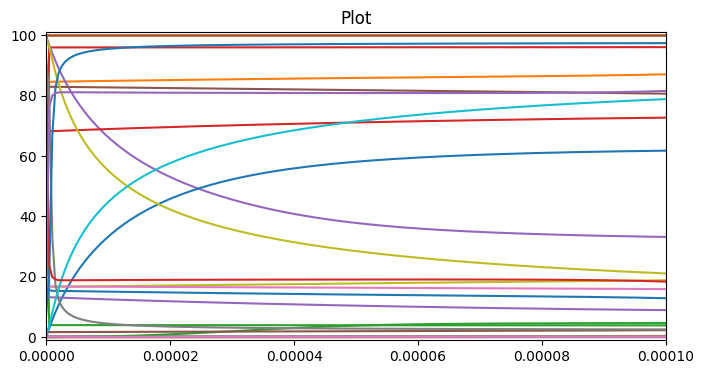

In [102]:
%time fig = create_figure(simulation, legend=False, format="-");

### BIO...526 ($t_1 = 0.1$)

In [103]:
example = get_example("BIOMD0000000526")
system = FODESystem(file=example.path_model(), read_ic = True, parser=example.read).remove_parameters_ic()
RRsystem = FODESystem(file=example.path_model(), read_ic = True, parser=example.read, field = RR).remove_parameters_ic()
x0 = array([float(RRsystem.ic.get(v, 0)) for v in RRsystem.variables])
norm_x0 = norm(x0, ord=2)
fx0 = array(RRsystem.derivative(..., *x0), dtype=x0.dtype)
norm_fx0 = norm(fx0, ord=2)
print(f"Original system size: {RRsystem.size}")
print(f"Initial state: |x_0| = {norm_x0} ## |f(x_0)| = {norm_fx0}")

Original system size: 18
Initial state: |x_0| = 3836.0085453502315 ## |f(x_0)| = 2449.671993477863


In [110]:
## Defining time frame
t0 = 0.0; t1 = 0.1; tstep = (t1-t0)/200; print(t1)

0.1


In [111]:
%time simulation = RRsystem.simulate(t0,t1,x0,tstep)

CPU times: user 39.6 ms, sys: 0 ns, total: 39.6 ms
Wall time: 39.5 ms


CPU times: user 8.44 ms, sys: 8.92 ms, total: 17.4 ms
Wall time: 16.5 ms


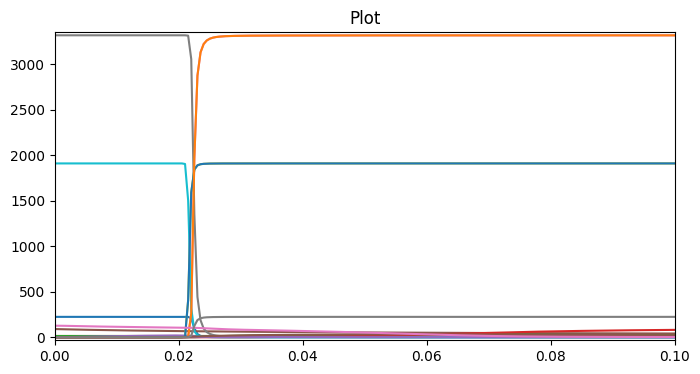

In [112]:
%time fig = create_figure(simulation, legend=False, format="-");

### MODEL1502270000 (simulation and lumping slow)

In [113]:
example = get_example("MODEL1502270000")
system = FODESystem(file=example.path_model(), read_ic = True, parser=example.read).remove_parameters_ic()
RRsystem = FODESystem(file=example.path_model(), read_ic = True, parser=example.read, field = RR).remove_parameters_ic()
x0 = array([float(RRsystem.ic.get(v, 0)) for v in RRsystem.variables])
norm_x0 = norm(x0, ord=2)
fx0 = array(RRsystem.derivative(..., *x0), dtype=x0.dtype)
norm_fx0 = norm(fx0, ord=2)
print(f"Original system size: {RRsystem.size}")
print(f"Initial state: |x_0| = {norm_x0} ## |f(x_0)| = {norm_fx0}")

Original system size: 22
Initial state: |x_0| = 1000.0499987500625 ## |f(x_0)| = 651780122.0605216


In [142]:
## Defining time frame
t0 = 0.0; t1 = 70/norm_fx0; tstep = (t1-t0)/200; print(t1)

1.0739818173451459e-07


In [143]:
%time simulation = RRsystem.simulate(t0,t1,x0,tstep)

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 15.3 ms


CPU times: user 19.7 ms, sys: 0 ns, total: 19.7 ms
Wall time: 19 ms


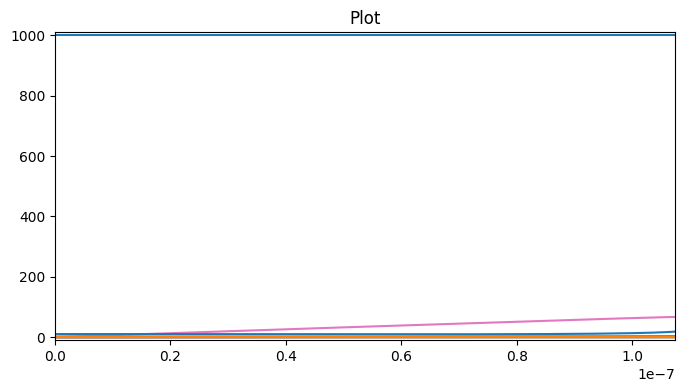

In [144]:
%time fig = create_figure(simulation, legend=False, format="-");